## 라이브러리 설치

In [11]:
!pip install -U langgraph langsmith langchain openai langchain_openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 kB 3.1 MB/s eta 0:00:00
  Using cached tiktoken-0.9.0-cp310-cp310-macosx_11_0_arm64.whl (1.0 MB)
  Using cached regex-2024.11.6-cp310-cp310-macosx_11_0_arm64.whl (284 kB)

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


## API Key 설정


In [14]:
import os
from uuid import uuid4
from dotenv import load_dotenv

load_dotenv()  # .env를 읽어서 os.environ에 적용

unique_id = uuid4().hex[0:8]

# UNIQUE_ID를 동적으로 적용
project_name = os.getenv("LANGCHAIN_PROJECT", "").replace("${UNIQUE_ID}", unique_id)
os.environ["LANGCHAIN_PROJECT"] = project_name


In [5]:
unique_id

'1b57d842'

## StateGraph 생성

그래프를 정의할 때 가장 먼저 해야 할 일은 그래프의 상태(State)를 정의하는 것입니다. 
상태는 그래프의 스키마와 상태에 대한 업데이트를 적용하는 방법을 지정하는 리듀서(reducer) 함수로 구성됩니다. 
우리의 예시에서 상태(State)는 하나의 키를 가진 TypedDict로 정의되며, 이 키는 messages입니다. 
messages 키는 add_messages 리듀서 함수로 주석이 달려 있으며, 이는 LangGraph에게 새로운 메시지를 기존 목록에 추가하도록 지시하고, 덮어쓰지 않도록 합니다. 주석이 없는 상태 키는 각 업데이트 시 덮어써지며 가장 최근의 값이 저장됩니다. 
참고 ( https://langchain-ai.github.io/langgraph/reference/graphs/?h=add+messages#add_messages )

In [15]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]
    
graph_builder = StateGraph(State)

In [16]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o",temperature=0)

def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)
graph_builder.set_entry_point("chatbot")
graph_builder.set_finish_point("chatbot")
graph = graph_builder.compile()


In [9]:
!pip install -qU duckduckgo-search langchain-community


[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
from langchain_community.tools import DuckDuckGoSearchRun

tool = DuckDuckGoSearchRun()
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

"Langraph: nodes, states, and edges. At the heart of LangGraph is the concept of a stateful graph:. State: Represents the context or memory that is maintained and updated as the computation ... LangGraph is a message-passing framework for building modular, graph-based systems. At its core, it focuses on communication between nodes via structured states and logical edges, enabling a ... In LangGraph, each node represents an LLM agent, and the edges are the communication channels between these agents. This structure allows for clear and manageable workflows, where each agent performs specific tasks and passes information to other agents as needed. State management. One of LangGraph's standout features is its automatic state ... LangGraph. Again considering the image blow, a snippet of LangGraph Python code is shown on the left, with the graph drawn out on the right. You can see in the code where the node is defined, builder.add_node with a ReturnNodeValue.For each node having an edge def

In [23]:
from typing import Annotated

from langchain_openai import ChatOpenAI
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = DuckDuckGoSearchRun()
tools = [tool]
llm = ChatOpenAI(model="gpt-4o",temperature=0,)
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")



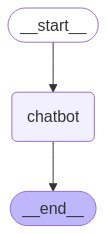

In [24]:
from IPython.display import Image, display
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass